# Predicting Resale Value of Knives from a Texas Government Surplus Store

## Using Machine Learning to Support an Ebay Store's Financial Success


### Data Exploration and Modeling


**Author:** Dylan Dey


### Model

In [1]:
from sklearn.model_selection import train_test_split
import os
from collections import Counter

import pandas as pd 
import  json
import requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ast
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Flatten, GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Model
from keras import models
from keras import layers
import tensorflow as tf
from keras.utils import plot_model
from sklearn.metrics import mean_absolute_error
from keras_preprocessing.image import ImageDataGenerator

In [2]:
plt.style.use('dark_background')

### Function Definition

In [3]:
def apply_iqr_filter(df):
    
    price_Q1 = df['converted_price'].quantile(0.25)
    price_Q3 = df['converted_price'].quantile(0.75)
    price_iqr = price_Q3 - price_Q1

    profit_Q1 = df['profit'].quantile(0.25)
    profit_Q3 = df['profit'].quantile(0.75)
    profit_iqr = profit_Q3 - profit_Q1

    ROI_Q1 = df['ROI'].quantile(0.25)
    ROI_Q3 = df['ROI'].quantile(0.75)
    ROI_iqr = ROI_Q3 - ROI_Q1

    price_upper_limit = price_Q3 + (1.5 * price_iqr)
    price_lower_limit = price_Q1 - (1.5 * price_iqr)

    profit_upper_limit = profit_Q3 + (1.5 * profit_iqr)
    profit_lower_limit = profit_Q1 - (1.5 * profit_iqr)

    ROI_upper_limit = ROI_Q3 + (1.5 * ROI_iqr)
    ROI_lower_limit = ROI_Q1 - (1.5 * ROI_iqr)
    
#     print(f'Brand: {df.brand[0]}')
#     print(f'price upper limit: ${np.round(price_upper_limit,2)}')
#     print(f'price lower limit: ${np.round(price_lower_limit,2)}')
#     print('-----------------------------------')
#     print(f'profit upper limit: ${np.round(profit_upper_limit,2)}')
#     print(f'profit lower limit: ${np.round(profit_lower_limit,2)}')
#     print('-----------------------------------')
#     print(f'ROI upper limit: {np.round(ROI_upper_limit,2)}%')
#     print(f'ROI lower limit: {np.round(ROI_lower_limit,2)}%')
#     print('-----------------------------------')

    
    new_df = df[(df['converted_price'] < price_upper_limit) &
                (df['converted_price'] > price_lower_limit) &
                (df['profit'] < profit_upper_limit) &
                (df['ROI'] > profit_lower_limit) &
                (df['profit'] < ROI_upper_limit) &
                (df['ROI'] > ROI_lower_limit)]
    
    return new_df
#download jpg urls from dataFrame
def download(row):
    filename = os.path.join(root_folder, str(row.name) + im_extension)

# create folder if it doesn't exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    url = row.Image
#     print(f"Downloading {url} to {filename}")
    
    try:
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
    except:
        print(f'{filename} error')


def cardinality_threshold(column,threshold=0.75,return_categories_list=True):
    #calculate the threshold value using
    #the frequency of instances in column
    threshold_value=int(threshold*len(column))
    #initialize a new list for lower cardinality column
    categories_list=[]
    #initialize a variable to calculate sum of frequencies
    s=0
    #Create a dictionary (unique_category: frequency)
    counts=Counter(column)

    #Iterate through category names and corresponding frequencies after sorting the categories
    #by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the total sum
        s += dict(counts)[i]
        #append the category name to the categories list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s >= threshold_value:
            break
      #append the new 'Other' category to list
    categories_list.append('Other')

    #Take all instances not in categories below threshold  
    #that were kept and lump them into the
    #new 'Other' category.
    new_column = column.apply(lambda x: x if x in categories_list else 'Other')

    #Return the transformed column and
    #unique categories if return_categories = True
    if(return_categories_list):
        return new_column,categories_list
    #Return only the transformed column if return_categories=False
    else:
        return new_column
    
def fix(col):
    dd = dict()
    for d in col:
        values = list(d.values())
        if len(values) == 2:
            dd[values[0]] = values[1]
    return dd

#function for extracted item Specifics from Shopping API data
def transform_item_specifics(df, perc=90.0):

    df.dropna(subset=['ItemSpecifics'], inplace=True)
    df['ItemSpecifics'] = df['ItemSpecifics'].apply(lambda x: ast.literal_eval(x))
    df['item_list'] = df['ItemSpecifics'].apply(lambda x: x['NameValueList'])

    df['ItemSpecifics'] = df['ItemSpecifics'].apply(lambda x: [x['NameValueList']] if isinstance(x['NameValueList'], dict) else x['NameValueList'])

    df['ItemSpecifics'] = df['ItemSpecifics'].apply(fix)

    df = pd.json_normalize(df['ItemSpecifics'])

    min_count =  int(((100-perc)/100)*df.shape[0] + 1)
    mod_df = df.dropna(axis=1, 
                       thresh=min_count)

    return mod_df

# This function removes noisy data
#lots/sets/groups of knives can
#confuse the model from predicting
#the appropriate value of individual knives
def data_cleaner(df):
    lot = re.compile('(?<!-\S)lot(?![^\s.,:?!])')
    group = re.compile('(group)')
    is_set = re.compile('(?<!-\S)set(?![^\s.,?!])')
    df['title'] = df['title'].str.lower()
    trim_list = [lot,group,is_set]
    for item in trim_list:
        df.loc[df['title'].apply(lambda x: re.search(item, x)).notnull(), 'trim'] = 1 
    to_drop = df.loc[df['trim'] == 1].index
    df.drop(to_drop, inplace=True)
    df.drop('trim', axis=1, inplace=True)
    
    return df



def prepare_listed(listed_data_df, Ids_df):
    listed_data_df.drop('galleryPlusPictureURL', axis=1, inplace=True)
   
    Ids_df.rename({'Title': 'title',
                   'ItemID': 'itemId'},
                    axis=1,inplace=True)
    
    Ids_df.drop(['ConditionID','ConvertedCurrentPrice'], 
                         axis=1, inplace=True)
    Ids_df['title'] = Ids_df['title'].str.lower()
    
    df_merged = listed_data_df.merge(Ids_df)

    df_spec = transform_item_specifics(df_merged, perc=65.0)
    
    df_spec.drop('Brand', axis=1, inplace=True)
    
    tot_listed_df = df_merged.join(df_spec)

    listed_knives = data_cleaner(tot_listed_df).copy()
    listed_knives.drop(['sellingStatus', 'shippingInfo', 
                        'GalleryURL', 'ItemSpecifics', 
                        'item_list', 'listingInfo'], 
                        axis=1, inplace=True)
    listed_used_knives = listed_knives.loc[listed_knives['condition'] != 1000.0]
    listed_used_knives.reset_index(drop=True, inplace=True)
    
    return listed_used_knives


def prepare_tera_df(df, x, overhead_cost=3):
    df['price_in_US'] = df['price_in_US'].str.replace("$", "")
    df['price_in_US'] = df['price_in_US'].str.replace(",", "")
    df['price_in_US'] = df['price_in_US'].apply(float)
    
    df['shipping_cost'] = df['shipping_cost'].str.replace("$", "")
    df['shipping_cost'] = df['shipping_cost'].str.replace(",", "")
    df['shipping_cost'] = df['shipping_cost'].apply(float)
    
    df['brand'] = list(bucket_dict.keys())[x]
    df['converted_price'] = (df['price_in_US'] + df['shipping_cost'])
    df['cost'] = list(bucket_dict.values())[x] + overhead_cost + 4.95
    df['profit'] = ((df['converted_price']*.87) -  df['cost'])
    df['ROI'] = (df['profit']/ df['cost'])*100.0
    
    return df   
    

### Load Data

In [4]:
#load Finding API data
df_bench = pd.read_csv("listed_data/df_bench.csv")
df_buck = pd.read_csv("listed_data/df_buck.csv")
df_case = pd.read_csv("listed_data/df_case.csv")
df_caseXX = pd.read_csv("listed_data/df_CaseXX.csv")
df_crkt = pd.read_csv("listed_data/df_crkt.csv")
df_kersh = pd.read_csv("listed_data/df_kershaw.csv")
df_sog = pd.read_csv("listed_data/df_sog.csv")
df_spyd = pd.read_csv("listed_data/df_spyderco.csv")
df_vict = pd.read_csv("listed_data/df_victorinox.csv")

#load Shopping API data
bench = pd.read_csv("listed_data/benchIds.csv")
buck = pd.read_csv("listed_data/buckIds.csv")
case = pd.read_csv("listed_data/caseIds.csv")
caseXX = pd.read_csv("listed_data/caseXXIds.csv")
crkt = pd.read_csv("listed_data/crktIds.csv")
kershaw = pd.read_csv("listed_data/kershawIds.csv")
sog = pd.read_csv("listed_data/sogIds.csv")
spyd = pd.read_csv("listed_data/spydIds.csv")
vict = pd.read_csv("listed_data/victIds.csv")

#Load scraped terapeak sold data
sold_bench = pd.read_csv("terapeak_data/bench_scraped2.csv")
sold_buck1 = pd.read_csv("terapeak_data/buck_scraped2.csv")
sold_buck2 = pd.read_csv("terapeak_data/buck_scraped2_reversed.csv")
sold_case = pd.read_csv("terapeak_data/case_scraped2.csv")
sold_caseXX1 = pd.read_csv("terapeak_data/caseXX_scraped2.csv")
sold_caseXX2 = pd.read_csv("terapeak_data/caseXX2_reversed.csv")
sold_crkt = pd.read_csv("terapeak_data/crkt_scraped.csv")
sold_kershaw1 = pd.read_csv("terapeak_data/kershaw_scraped2.csv")
sold_kershaw2 = pd.read_csv("terapeak_data/kershaw_scraped2_reversed.csv")
sold_sog = pd.read_csv("terapeak_data/SOG_scraped2.csv")
sold_spyd = pd.read_csv("terapeak_data/spyd_scraped2.csv")
sold_vict1 = pd.read_csv("terapeak_data/vict_scraped.csv")
sold_vict2 = pd.read_csv("terapeak_data/vict_reversed.csv")

sold_list = [sold_bench,sold_buck1,
             sold_buck2,sold_case,
             sold_caseXX1,sold_caseXX2,
             sold_crkt,sold_kershaw1,
             sold_kershaw2,sold_sog, 
             sold_spyd, sold_vict1,
             sold_vict2]


listed_df = pd.concat([df_bench,df_buck,
                       df_case,df_caseXX,
                       df_crkt,df_kersh,
                       df_sog,df_spyd,
                       df_vict])

used_listed_df = listed_df.loc[listed_df['condition'] != 1000.0].copy()

cols = ['title','pictureURLLarge','converted_price','brand','profit','ROI']
used_listed = used_listed_df[cols].copy()
used_listed.dropna(subset=['pictureURLLarge'], inplace=True)

used_listed.reset_index(drop=True, inplace=True)


bucket_dict = {'benchmade': 45.0,
               'buck': 20.0,
               'case': 20.0,
               'crkt': 15.0,
               'kershaw': 15.0,
               'sog': 15.0,
               'spyderco': 30.0,
               'victorinox': 20.0
               }

### Prepare Data

In [5]:
for dataframe in sold_list:
    dataframe.rename({'Text': 'title',
                      'shipping_': 'shipping_cost'},
                     axis=1, inplace=True)

    dataframe['date_sold'] = pd.to_datetime(dataframe['date_sold'])

sold_buck = pd.concat([sold_buck1,sold_buck2])
sold_caseXX = pd.concat([sold_caseXX1,sold_caseXX2])
sold_kershaw = pd.concat([sold_kershaw1,sold_kershaw2])
sold_vict = pd.concat([sold_vict1,sold_vict2])

sold_bench = prepare_tera_df(sold_bench, 0)
sold_buck = prepare_tera_df(sold_buck, 1)
sold_case = prepare_tera_df(sold_case, 2)
sold_caseXX = prepare_tera_df(sold_caseXX, 2)
sold_crkt = prepare_tera_df(sold_crkt, 3)
sold_kershaw = prepare_tera_df(sold_kershaw, 4)
sold_sog = prepare_tera_df(sold_sog, 5)
sold_spyd = prepare_tera_df(sold_spyd, 6)
sold_vict = prepare_tera_df(sold_vict, 7)

In [6]:
for dataframe in sold_list:
    dataframe['title'] = dataframe['title'].str.lower()
    dataframe['title'] = dataframe['title'].str.strip()
    dataframe.drop_duplicates(
        subset = ['date_sold','price_in_US', 
                  'shipping_cost'],
        keep = 'last', inplace=True)

In [7]:
sold_df = pd.concat([sold_bench, sold_buck,
                     sold_case, sold_caseXX, 
                     sold_crkt, sold_kershaw,
                     sold_sog, sold_spyd,
                     sold_vict]) 

sold_knives = data_cleaner(sold_df).copy()


df = pd.concat([sold_knives,used_listed]).copy()
df['Image'].fillna(df['pictureURLLarge'], inplace=True)

df = apply_iqr_filter(df).copy()
df.reset_index(drop=True, inplace=True)

In [8]:
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return text

In [9]:
df['title'] = df['title'].apply(clean_text)

In [10]:
df['title'].sample(20).apply(print)

kershaw crown knife 3160 liner lock plain edge single blade folding pocket kershaw crown knife 3160 liner lock plain edge single blade folding pocket 
533 black kershaw 1230 diode liner lock knife533 black kershaw 1230 diode liner lock knife
victorinox switzerland rosfrei 25 multitool
good used buck knife knives model 184 large and small pouch in good condition
19731976 victorinox alox advertising knife  sprague meter company19731976 victorinox alox advertising knife  sprague meter company
used sog flash ii pocket knife folding combo blade gused sog flash ii pocket knife folding combo blade g
victorinox switzerland stainless rostfrei red swiss army knife multi function
vintage 1972 case xx usa 4 blade boy scout knife melon tester 640045r eight dotsvintage 1972 case xx usa 4 blade boy scout knife melon tester 640045r eight dots
spyderco pacific salt h1 sekicity japan plain edge black pocket knife 726spyderco pacific salt h1 sekicity japan plain edge black pocket knife 726
kershaw emerso

46556    None
37711    None
78326    None
67689    None
59498    None
52974    None
78328    None
30489    None
57084    None
49998    None
70566    None
35293    None
7541     None
9152     None
35390    None
72850    None
2943     None
73144    None
35840    None
74578    None
Name: title, dtype: object

In [11]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['word_count'] = df['title'].apply(lambda x: len(x.split()))

In [12]:
def avg_word_len(x):
    words = x.split()
    word_len = 0
    for word in words:
        word_len += len(word)
        
    return word_len / len(words)

In [13]:
df['avg_word_len'] = df['title'].apply(lambda x: avg_word_len(x))

In [14]:
# pd.options.plotting.backend = "plotly"

<AxesSubplot:title={'center':'Word Count Distribution'}, ylabel='Frequency'>

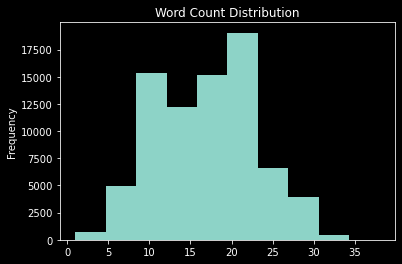

In [15]:
df['word_count'].plot(kind = 'hist', title = 'Word Count Distribution')

<AxesSubplot:title={'center':'Avg_Word_len Distribution'}, ylabel='Frequency'>

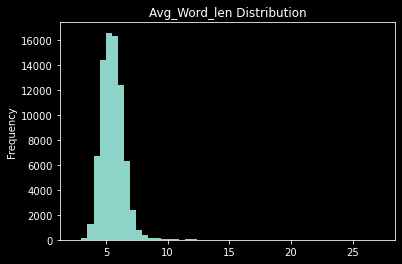

In [16]:
df['avg_word_len'].plot(kind='hist', bins = 50, title = 'Avg_Word_len Distribution')

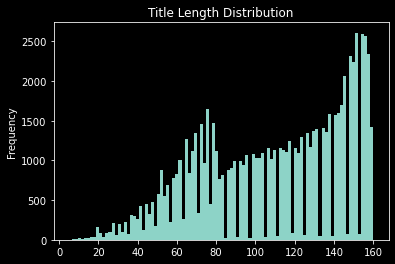

In [17]:
df['title_len'].plot(kind='hist', bins= 100,title = 'Title Length Distribution');

In [18]:
df.describe()

,price_in_US,shipping_cost,converted_price,cost,profit,ROI,title_len,word_count,avg_word_len
count,66768.000000,66768.000000,78330.000000,66768.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000
mean,45.969092,4.315289,50.044127,28.754727,15.728080,54.837503,109.446062,17.086340,5.534031
std,35.153294,3.598604,36.026730,7.272042,28.695811,103.741175,36.561769,6.116623,0.982619
min,0.010000,0.000000,6.940000,22.950000,-38.812500,-73.853309,5.000000,1.000000,2.500000
25%,19.990000,0.000000,22.182500,22.950000,-5.600000,-22.325490,78.000000,12.000000,4.888889
50%,35.000000,4.950000,38.740000,27.950000,7.065000,26.064401,114.000000,17.000000,5.466667
75%,62.000000,5.900000,67.490000,27.950000,29.204950,102.866646,144.000000,22.000000,6.000000
max,167.000000,80.000000,167.490000,52.950000,109.153000,605.666667,160.000000,38.000000,27.200000


### Neural network with "title" column as input

In [19]:
df_title = df.loc[:, ['title', 'converted_price']]


df_title.rename({'title': 'data',
                 'converted_price': 'labels'},
                axis=1, inplace=True)

In [20]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78330 entries, 0 to 78329
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    78330 non-null  object 
 1   labels  78330 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [21]:
# df_title['labels'] = (df_title['labels']/mean_price)
Y = df_title['labels'].values

In [22]:
df_title['data'].sample(10).apply(print)

buck 055 lockback folding pocket knife hunting fishing campingbuck 055 lockback folding pocket knife hunting fishing camping
knife lot case usastacked leather knife and pocket knifes
buck 373 trio wood handle folding pocket knife buck 373 trio wood handle folding pocket knife 
victorinox swiss made stainless black single blade pocket knifevictorinox swiss made stainless black single blade pocket knife
snapon kershaw 1440 folding pocket knife wclip the chubby ker1440snapon kershaw 1440 folding pocket knife wclip the chubby ker1440
case xx navy blue jigged bone large stockman knife 425 closedcase xx navy blue jigged bone large stockman knife 425 closed
buck 327 folding knifebuck 327 folding knife
victorinox camper swiss army knifevictorinox camper swiss army knife
victorinox forester large pocket knife with wood saw  black 083633
nice 2016 buck usa 290 linerlocking knifenice 2016 buck usa 290 linerlocking knife


5465     None
68843    None
12587    None
59545    None
44802    None
30503    None
15798    None
63161    None
75504    None
8100     None
Name: data, dtype: object

In [23]:
df_train, df_test, Ytrain, Ytest = train_test_split(df_title['data'],
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=51)

In [24]:
X_val, X_test, Y_val, Y_test = train_test_split(df_test, 
                                                Ytest, 
                                                test_size=0.5, 
                                                random_state=51)

### GRU

In [25]:
#Vectorize vocab 
voc_size = 25000
max_len = 30
embedding_features = 35
tokenizer = Tokenizer(num_words=voc_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train) 
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [26]:
#add padding to ensure all inputs are the same size
data_train = pad_sequences(sequences_train, maxlen=max_len, padding= 'post', truncating = 'post')
data_val = pad_sequences(sequences_val, maxlen=max_len, padding= 'post', truncating = 'post')
data_test = pad_sequences(sequences_test, maxlen=max_len, padding= 'post', truncating = 'post')

In [27]:
data_train.shape

(54831, 30)

In [28]:
model = models.Sequential()
model.add(Embedding(voc_size, embedding_features, input_length = max_len)) 
model.add(GRU(100))
model.add(Dense(64, activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 35)            875000    
_________________________________________________________________
gru (GRU)                    (None, 100)               41100     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 924,677
Trainable params: 924,677
Non-trainable params: 0
__________________________________________________

In [29]:
# Compile and fit
model.compile(
  loss='MSE',
  optimizer='adam',
  metrics=['mae']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=10,
  validation_data=(data_val, Y_val)
)

Training model...
Epoch 1/10
1714/1714 [==============================] - 28s 16ms/step - loss: 1438.4380 - mae: 29.3914 - val_loss: 1283.4006 - val_mae: 28.2261
Epoch 2/10
1714/1714 [==============================] - 28s 17ms/step - loss: 1394.6547 - mae: 29.0320 - val_loss: 1284.1249 - val_mae: 28.1231
Epoch 3/10
1714/1714 [==============================] - 28s 17ms/step - loss: 1212.7058 - mae: 26.3165 - val_loss: 570.7115 - val_mae: 16.5982
Epoch 4/10
1714/1714 [==============================] - 29s 17ms/step - loss: 586.3848 - mae: 16.7241 - val_loss: 473.6166 - val_mae: 15.1923
Epoch 5/10
1714/1714 [==============================] - 30s 17ms/step - loss: 484.0551 - mae: 14.9979 - val_loss: 458.1174 - val_mae: 14.2479
Epoch 6/10
1714/1714 [==============================] - 28s 16ms/step - loss: 414.4722 - mae: 13.7933 - val_loss: 441.5680 - val_mae: 14.2144
Epoch 7/10
1714/1714 [==============================] - 29s 17ms/step - loss: 364.4004 - mae: 12.8894 - val_loss: 426.7194 - 

In [30]:
pred=model.predict(data_test)

In [31]:
test_results = model.evaluate(data_test, Y_test)

368/368 [==============================] - 1s 3ms/step - loss: 445.5005 - mae: 13.7965


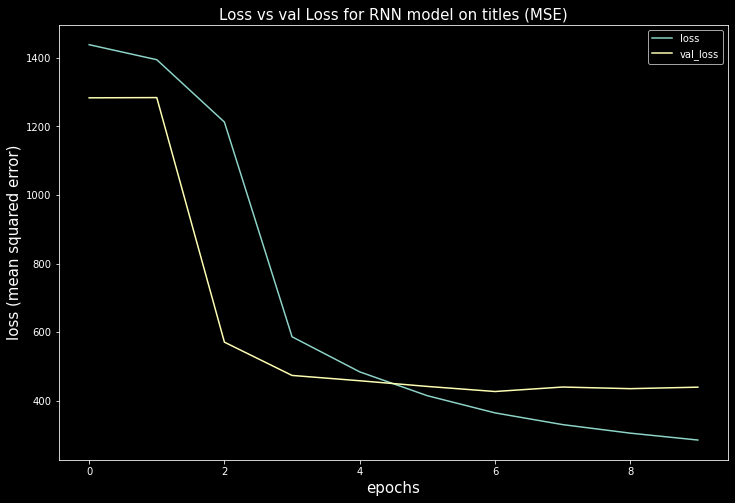

In [32]:
fig = plt.subplots(figsize=(12,8))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss vs val Loss for RNN model on titles (MSE)", fontsize=15)
plt.xlabel("epochs", fontsize=15)
plt.ylabel("loss (mean squared error)", fontsize=15)
plt.legend();
plt.savefig('images/RNN_GRU_MSE1.png')

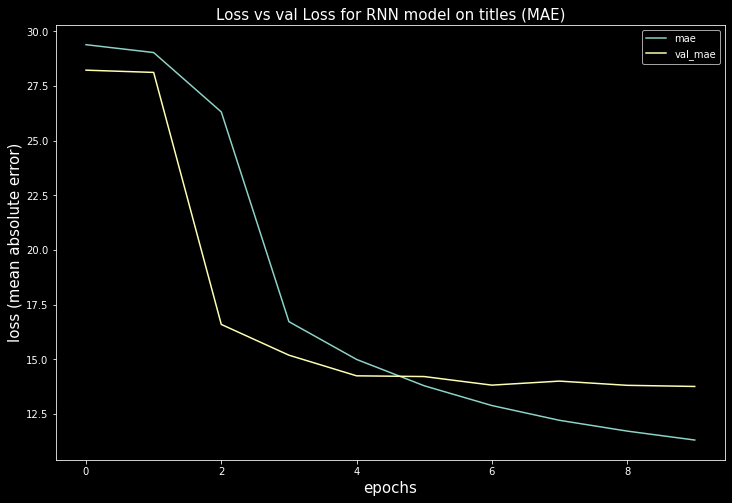

In [33]:
fig = plt.subplots(figsize=(12,8))
plt.plot(r.history['mae'], label='mae')
plt.plot(r.history['val_mae'], label='val_mae')
plt.title("Loss vs val Loss for RNN model on titles (MAE)", fontsize=15)
plt.xlabel("epochs", fontsize=15)
plt.ylabel("loss (mean absolute error)", fontsize=15)
plt.legend();
plt.savefig('images/RNN_GRU_MAE1.png')

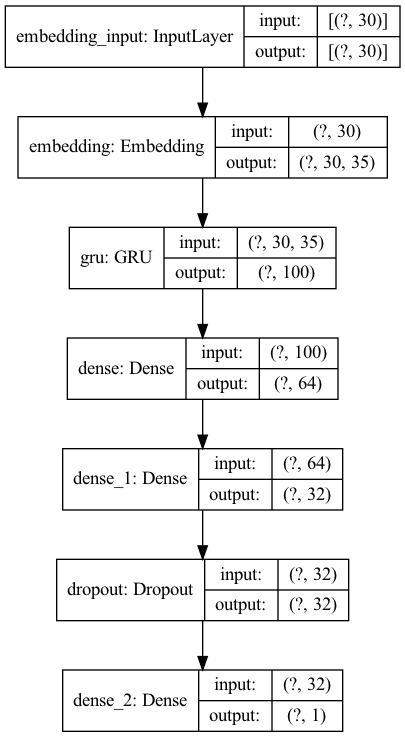

In [34]:
plot_model(model,show_shapes=True, to_file='images/RNN_GRU1_arc.png')

In [35]:
test_mae = mean_absolute_error(Y_test, pred)

In [36]:
RMSE = np.sqrt(test_results[0])

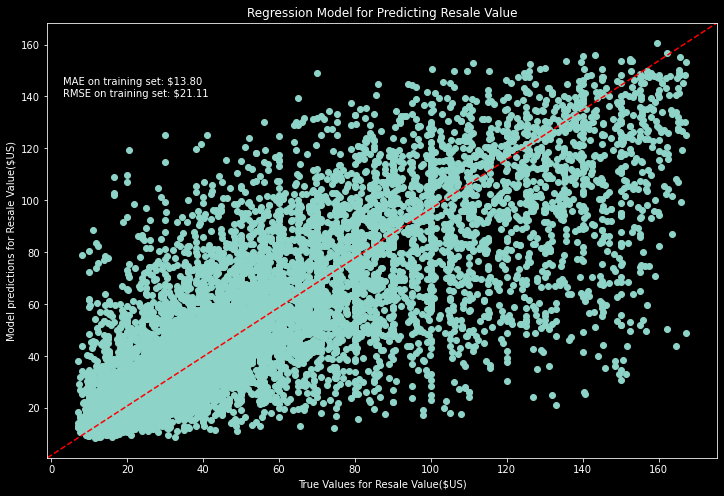

In [37]:
string_score = f'\nMAE on training set: ${test_mae:.2f}'
string_score += f'\nRMSE on training set: ${RMSE:.2f}'
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(Y_test, pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 140, string_score)
plt.title('Regression Model for Predicting Resale Value')
plt.ylabel('Model predictions for Resale Value($US)')
plt.xlabel('True Values for Resale Value($US)')
plt.savefig('images/regression_GRU_relu1.png');

In [38]:
df_title['labels'].describe()

count    78330.000000
mean        50.044127
std         36.026730
min          6.940000
25%         22.182500
50%         38.740000
75%         67.490000
max        167.490000
Name: labels, dtype: float64

In [39]:
df_title = df.loc[:, ['title', 'converted_price']]


df_title.rename({'title': 'data',
                 'converted_price': 'labels'},
                axis=1, inplace=True)

In [40]:
# df_title['labels'] = (df_title['labels']/mean_price)
Y = df_title['labels'].values

In [41]:
df_train, df_test, Ytrain, Ytest = train_test_split(df_title['data'],
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [42]:
X_val, X_test, Y_val, Y_test = train_test_split(df_test, 
                                                Ytest, 
                                                test_size=0.5, 
                                                random_state=42)

### LSTM

In [43]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 25000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE) 
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train) 
sequences_val = tokenizer.texts_to_sequences(X_val) 
sequences_test = tokenizer.texts_to_sequences(X_test)

In [44]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 32753 unique tokens.


In [45]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (54831, 41)


In [46]:
data_val = pad_sequences(sequences_val, maxlen=T)
print('Shape of data test tensor:', X_val.shape)

Shape of data test tensor: (11749,)


In [47]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', X_test.shape)

Shape of data test tensor: (11750,)


In [ ]:
# Create the RNN model
# We get to choose embedding dimensionality
D = 30
# Hidden state dimensionality
M = 35
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x) 
x = GlobalMaxPooling1D()(x)
x = Dense(62, activation='relu')(x)
x = Dense(32, activation='relu')(x) 
x = Dropout(0.3)(x)
x = Dense(1, activation='relu')(x)
model = Model(i, x)

In [ ]:
# Compile and fit
model.compile(
  loss='MSE',
  optimizer='adam',
  metrics=['mae']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=5,
  validation_data=(data_val, Y_val)
)

In [ ]:
model.summary()

In [ ]:
plot_model(model,show_shapes=True, to_file='images/RNN_LSTM_arc.png')

In [ ]:
pred=model.predict(data_test)

In [ ]:
test_results = model.evaluate(data_test, Y_test)

In [ ]:
RMSE = np.sqrt(test_results[0])

In [ ]:
fig = plt.subplots(figsize=(12,8))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss vs val Loss for RNN model on titles (MSE)", fontsize=15)
plt.xlabel("epochs", fontsize=15)
plt.ylabel("loss (mean squared error)", fontsize=15)
plt.legend()
plt.savefig('images/MSE_LSTM_relu.png');

In [ ]:
fig = plt.subplots(figsize=(12,8))
plt.plot(r.history['mae'], label='mae')
plt.plot(r.history['val_mae'], label='val_mae')
plt.title("Loss vs val Loss for RNN model on titles (MAE)", fontsize=15)
plt.xlabel("epochs", fontsize=15)
plt.ylabel("loss (mean absolute error)", fontsize=15)
plt.legend()
plt.savefig('images/MAE_LSTM_relu.png');

In [ ]:
test_mae = mean_absolute_error(Y_test, pred)

In [ ]:
string_score = f'\nMAE on training set: ${test_mae:.2f}'
string_score += f'\nMAE on training set: ${RMSE:.2f}'
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(Y_test, pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(5, 135, string_score)
plt.title('Regression Model for Predicting Resale Value')
plt.ylabel('Model predictions for Resale Value($US)')
plt.xlabel('True Values for Resale Value($US)')
plt.savefig("images/regression_LSTM_relu.png")

### CNN Titles

In [ ]:
# Create the CNN model

# We get to choose embedding dimensionality
D = 256



i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='relu')(x)

model = Model(i, x)

In [ ]:
# Compile and fit
model.compile(
  loss='MSE',
  optimizer='adam',
  metrics=['mae']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=5,
  validation_data=(data_val, Y_val)
)


In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['MSE'], label='MSE')
plt.plot(r.history['val_MSE'], label='val_MSE')
plt.legend();

### CNN using images as input

In [49]:
df_imgs = df.drop(['title', 'url', 
                   'date_sold', 'profit',
                   'ROI', 'brand', 'cost',
                   'pictureURLLarge'],
                     axis=1).copy()

In [50]:
df_imgs.dropna(subset=['Image'], inplace=True)

In [51]:
df_imgs.reset_index(drop=True, inplace=True)

In [52]:
df_imgs['file_index'] = df_imgs.index.values
df_imgs['file_index'] = df_imgs['file_index'].astype(str)

In [53]:
df_imgs['filename'] = df_imgs['file_index'] + '.jpg'

In [54]:
def download(row):
    filename = row.filepath

# create folder if it doesn't exist
#     os.makedirs(os.path.dirname(filename), exist_ok=True)

    url = row.Image
#     print(f"Downloading {url} to {filename}")
    
    try:
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
    except:
        print(f'{filename} error')

In [55]:
root_folder = 'C:/Users/12108/Documents/GitHub/Neural_Network_Predicting_Reseller_Success_Ebay/nn_images/'
df_imgs['filepath'] = root_folder + df_imgs['filename']

In [56]:
df_imgs['filepath'].sample(2).apply(print)

C:/Users/12108/Documents/GitHub/Neural_Network_Predicting_Reseller_Success_Ebay/nn_images/34547.jpg
C:/Users/12108/Documents/GitHub/Neural_Network_Predicting_Reseller_Success_Ebay/nn_images/69073.jpg


34547    None
69073    None
Name: filepath, dtype: object

In [57]:
# df_imgs.apply(download, axis=1)

#### All image files are stored locally for this project. The below markdown code is for reference.

```
img_list = os.listdir('C:/Users/12108/Documents/GitHub/Neural_Network_Predicting_Reseller_Success_Ebay/nn_images/')

img_df = df_imgs.loc[df_imgs['filename'].isin(img_list)].copy()

img_df.reset_index(drop=True, inplace=True)
```

```
img_df.rename({'Image': 'data',
               'converted_price': 'labels'},
                axis=1, inplace=True)
```

```
df_train, df_test, Ytrain, Ytest = train_test_split(img_df, Y, test_size=0.20)
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20)

train_generator=datagen.flow_from_dataframe(
dataframe=df_train,
directory= None,
x_col="filepath",
y_col="labels",
subset="training",
batch_size=100,
seed=55,
shuffle=True,
class_mode="raw")
    
valid_generator=datagen.flow_from_dataframe(
dataframe=df_train,
directory=None,
x_col="filepath",
y_col="labels",
subset="validation",
batch_size=100,
seed=55,
shuffle=True,
class_mode="raw")

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=None,
x_col="filepath",
y_col="labels",
batch_size=100,
seed=55,
shuffle=False,
class_mode="raw")
```

In [ ]:
# model = models.Sequential()

# model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu',
#                         input_shape=(256 ,256,  3)))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
#                         input_shape=(256 ,256,  3)))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Flatten())

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='linear'))

# model.compile(loss='MSE',
#               optimizer='Adam',
#                metrics=['mae', 'mse'])

# summary = model.fit(train_generator, epochs=3, validation_data=valid_generator)

In [62]:
model = tf.keras.models.load_model('cnn_grayscale_relu1.h5',  compile=False)

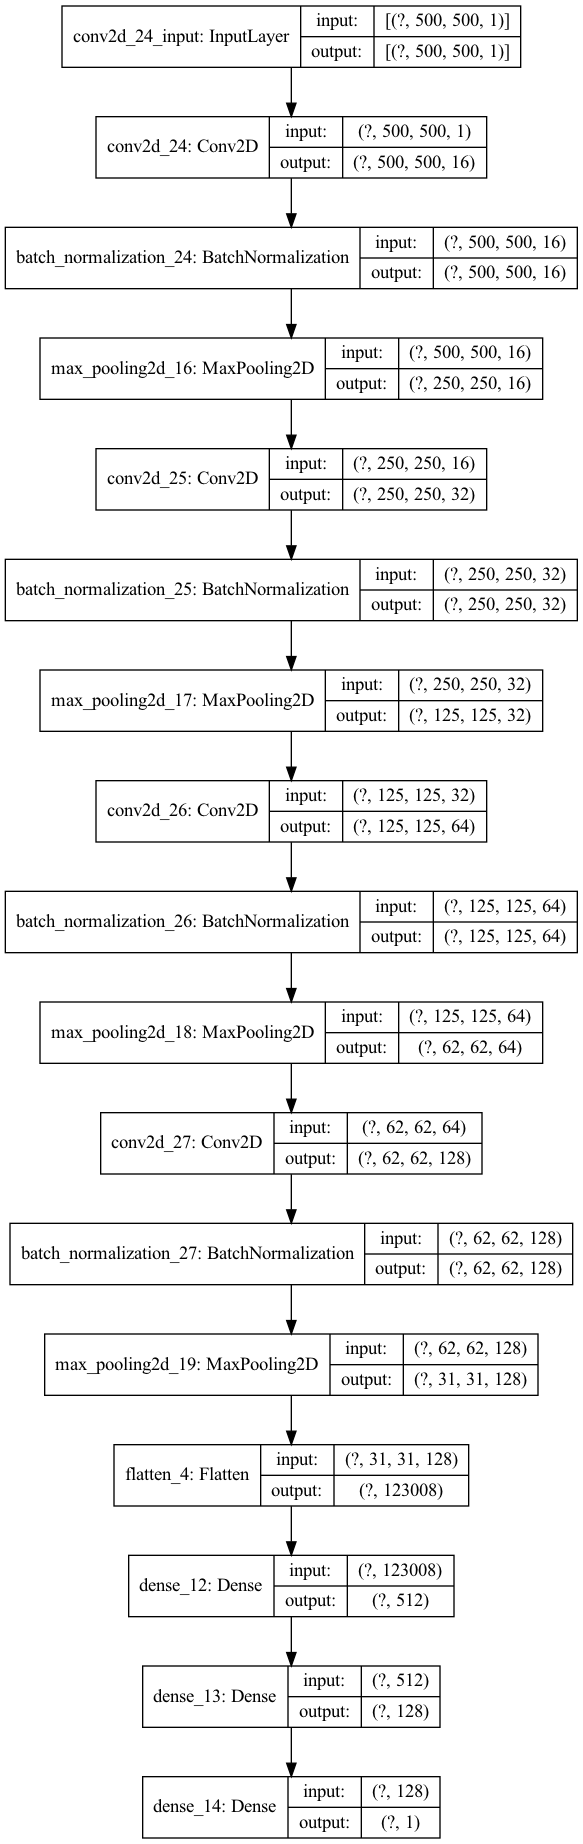

In [65]:
plot_model(model, show_shapes=True, to_file="images/CNN_architecture.png")

In [63]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 500, 500, 16)      160       
_________________________________________________________________
batch_normalization_24 (Batc (None, 500, 500, 16)      64        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 250, 250, 16)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 250, 250, 32)      4640      
_________________________________________________________________
batch_normalization_25 (Batc (None, 250, 250, 32)      128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 125, 125, 64)     

In [ ]:
model.evaluate(valid_generator)

In [ ]:
test_generator.reset()
pred=model.predict(test_generator,verbose=1)

In [ ]:
test_results = model.evaluate(test_generator)

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.plot
plt.title('model loss')
plt.ylabel('loss(mean absolute error)')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show();

# Results

### Recurrent Neural Network (Long Short Term Memory)

![RNN LSTM Arc](images/RNN_LSTM_arc.png)
![RNN CNN MAE](images/MAE_LSTM_relu.png)
![regression_plot](images/regression_LSTM_relu.png)

- The mean price of the 8 brands of knives sold on ebay is around \$50.00. A mean absolute error of about plus or minus /$13.80 is acceptable. 


### Convoluted Neural Network on Grayscale Images

![CNN_Architecture](images/CNN_architecture.png)
![CNN Regression Plot](images/Regression_CNN_relu1.png)
![CNN_MSE](images/CNN_MAE_relu1.png)

- The MAE when testing the CNN was roughly \$25.00. That is an error of plus or minus about 50\% of the mean price of knives sold. Not acceptable yet as compared to the RNN with titles. Will address in future work.

## Future Work
- Expand data to include other products readily purchasable at the Surplus Store. 

- Attempt data augmentation on the CNN image network

- Attempt to obtain more aspect data for sold knives. Some important aspect data is limited access to sellers who average a certain amount of money per month. 

In [ ]:
# # define two sets of inputs
# inputA = Input(shape=(32,))
# inputB = Input(shape=(128,))
# # the first branch operates on the first input
# x = Dense(8, activation="relu")(inputA)
# x = Dense(4, activation="relu")(x)
# x = Model(inputs=inputA, outputs=x)
# # the second branch opreates on the second input
# y = Dense(64, activation="relu")(inputB)
# y = Dense(32, activation="relu")(y)
# y = Dense(4, activation="relu")(y)
# y = Model(inputs=inputB, outputs=y)
# # combine the output of the two branches
# combined = concatenate([x.output, y.output])
# # apply a FC layer and then a regression prediction on the
# # combined outputs
# z = Dense(2, activation="relu")(combined)
# z = Dense(1, activation="linear")(z)
# # our model will accept the inputs of the two branches and
# # then output a single value
# model = Model(inputs=[x.input, y.input], outputs=z)